# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [3]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
import pickle
from IPython.display import display, display_markdown
from imblearn.over_sampling import SMOTE

# Magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [4]:
# Uncomment and use this cell when loading from the csv files in the Udacity workspace

# Load in the data
# print('Loading azdias data... ', end='')
# azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
# azdias = pd.read_csv('./Data/Udacity_AZDIAS_052018.csv', sep=';')
# print("Done!")

# print('Loading customers data... ', end='')
# # customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')
# customers = pd.read_csv('./Data/Udacity_CUSTOMERS_052018.csv', sep=';')
# print("Done!")

In [5]:
# Use this cell when loading from the saved pickle files

# # Load in the data
print('Loading azdias data... ', end='')
with open('azdias.pk', 'rb') as file_handle:
    azdias = pickle.load(file_handle)
print("Done!")

print('Loading customers data... ', end='')
with open('customers.pk', 'rb') as file_handle:
    customers = pickle.load(file_handle)
print("Done!")

Loading azdias data... Done!
Loading customers data... Done!


Start by printing out a few statistics about the dataframes; their sizes, column types, and how much data is missing.

In [6]:
def dataframe_overview(df):
    ''' Calculate and output various statistics about a dataframe
    
    Args:
        df (DataFrame): dataframe to analyse
    '''
    # Shape
    print("{} rows and {} columns.".format(df.shape[0], df.shape[1]))
    
    # Column types
    types = ['number', 'object']
    for col_type in types:
        count = df.select_dtypes(include=col_type).shape[1]
        print('{} columns of type \'{}\'.'.format(count, col_type))
    
    # Missing data
    missing_fraction = df.isna().mean().mean()
    print('{:.0%} of the data is null.'.format(missing_fraction))
    

In [7]:
print('Overview of azdias:')
dataframe_overview(azdias)
print('')
print('Overview of customers:')
dataframe_overview(customers)

Overview of azdias:
891221 rows and 366 columns.
360 columns of type 'number'.
6 columns of type 'object'.
10% of the data is null.

Overview of customers:
191652 rows and 369 columns.
361 columns of type 'number'.
8 columns of type 'object'.
20% of the data is null.


### 0.1 Invalid values
Loading the `azdias` data gives a warning that columns 18 and 19 have mixed types. Before we proceed, let's check out those columns to see what is triggering the warning.

In [8]:
azdias.iloc[:, 18].value_counts()

8      78023
9      62578
6      61253
4      60185
8.0    56418
3      50360
2      48276
9.0    45599
7      45021
6.0    44621
4.0    43727
3.0    36419
2.0    34955
7.0    32912
5      32292
5.0    23018
1      20997
1.0    15215
X        373
Name: CAMEO_DEUG_2015, dtype: int64

In [9]:
azdias.iloc[:, 19].value_counts()

51      77576
51.0    56118
41      53459
24      52882
41.0    38877
24.0    38276
14      36524
43      32730
14.0    26360
54      26207
43.0    23942
25      22837
54.0    19184
22      19173
25.0    16791
23      15653
13      15272
45      15206
22.0    13982
55      13842
52      11836
23.0    11097
13.0    11064
31      11041
45.0    10926
34      10737
55.0    10113
15       9832
52.0     8706
44       8543
31.0     7983
34.0     7787
12       7645
15.0     7142
44.0     6277
35       6090
32       6067
33       5833
12.0     5604
32.0     4287
35.0     4266
33.0     4102
XX        373
Name: CAMEO_INTL_2015, dtype: int64

We can see that column 18 (`CAMEO_DEUG_2015`) has 373 rows with the value `X`, and column 19 (`CAMEO_INTL_2015`) has 373 rows with the value `XX`. According to the `DIAS Attributes - Values 2017.xlsx` file these columns should only have integer values, so we should set these to NaN and set the column type to numeric. This will also fix the problem of having (for example) `35` and `35.0` counted as different values.


Whilst no other columns raised an error due to this, let's check out all columns that have been read in as type `object`. These could be hiding similar values if the column only contains strings.

In [10]:
# List to hold column names in
cols_with_x = []

# Iterate through columns with type object
for col in azdias.columns[azdias.dtypes == 'object']:
    # Count the number of values with /X+/ (i.e. X, XX)
    xs_found = azdias[col].str.match(r'X+', na=False).sum()
    # If found, print the column name and number found
    if xs_found > 0:
        print("Found {} values matching '/X+/' in column '{}'.".format(xs_found, col))
        cols_with_x.append(col)
        
cols_with_x

Found 373 values matching '/X+/' in column 'CAMEO_DEU_2015'.
Found 373 values matching '/X+/' in column 'CAMEO_DEUG_2015'.
Found 373 values matching '/X+/' in column 'CAMEO_INTL_2015'.


['CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'CAMEO_INTL_2015']

There are three columns (`CAMEO_DEU_2015`, `CAMEO_DEUG_2015`, `CAMEO_INTL_2015`) that have invalid X or XX values. We'll adapt the code above to define a function to replace these values with NaN.

In [11]:
def replace_invalid_x_values(df):
    ''' Replace invalid values ('X', 'XX') with np.nan and convert to numeric if possible
    
    Args:
        df (DataFrame): dataframe to process
    Returns:
        df (DataFrame): processed dataframe
    '''
    # Iterate through all columns with type object
    for col in df.columns[df.dtypes == 'object']:
        xs_found = df[col].str.match(r'X+', na=False).sum()
        if xs_found > 0:
            df[col] = df[col].replace(r'X+', np.nan, regex=True)
            print("Found {} values matching '/X+/' in column '{}'. replaced with NaN.".format(xs_found, col))
            # If possible, convert to numeric
            df[col] = pd.to_numeric(df[col], errors='ignore')
    
    return df

The `DIAS Attributes - Values 2017.xlsx` file tells us that some columns are using values other than NaN to denote missing data; such as -1, 0, or 9. We should replace these values with NaN to get a better picture of missing data in the dataset. To do this efficiently, we can use the Excel file to generate a mapping of column names to values used for unknown data.

In [12]:
# Use the provided Excel file to generate a mapping of columns to the values used for unknown data
# Load in the Excel file
attributes_df = pd.read_excel('DIAS Attributes - Values 2017.xlsx', skiprows=[0])
attributes_df.head()

,Unnamed: 0,Attribute,Description,Value,Meaning
0,NaN,AGER_TYP,best-ager typology,-1,unknown
1,NaN,NaN,NaN,0,no classification possible
2,NaN,NaN,NaN,1,passive elderly
3,NaN,NaN,NaN,2,cultural elderly
4,NaN,NaN,NaN,3,experience-driven elderly


In [13]:
# Drop the empty first column, and forward fill in the NaNs in the Attribute and Description columns
attributes_df.drop(labels=['Unnamed: 0'], axis=1, inplace=True)
attributes_df[['Attribute', 'Description']] = attributes_df[['Attribute', 'Description']].fillna(method='ffill')
attributes_df.head()

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,AGER_TYP,best-ager typology,0,no classification possible
2,AGER_TYP,best-ager typology,1,passive elderly
3,AGER_TYP,best-ager typology,2,cultural elderly
4,AGER_TYP,best-ager typology,3,experience-driven elderly


In [14]:
# Filter down to only the rows concerning values for unknown data
unknown_val_df = attributes_df[['Attribute', 'Value']][attributes_df['Meaning'].str.startswith('unknown', na=False)]
unknown_val_df.head()

,Attribute,Value
0,AGER_TYP,-1
5,ALTERSKATEGORIE_GROB,"-1, 0"
11,ALTER_HH,0
33,ANREDE_KZ,"-1, 0"
40,BALLRAUM,-1


In [15]:
# Convert to dict, and split out strings into lists of ints
unknown_value_dict = dict(zip(unknown_val_df['Attribute'], unknown_val_df['Value']))

for k, v in unknown_value_dict.items():
    if type(v) == str:
        unknown_value_dict[k] = list(map(int, list(v.split(','))))

unknown_value_dict

{'AGER_TYP': -1,
 'ALTERSKATEGORIE_GROB': [-1, 0],
 'ALTER_HH': 0,
 'ANREDE_KZ': [-1, 0],
 'BALLRAUM': -1,
 'BIP_FLAG': -1,
 'CAMEO_DEUG_2015': -1,
 'CAMEO_DEUINTL_2015': -1,
 'CJT_GESAMTTYP': 0,
 'D19_KK_KUNDENTYP': -1,
 'EWDICHTE': -1,
 'FINANZTYP': -1,
 'FINANZ_ANLEGER': -1,
 'FINANZ_HAUSBAUER': -1,
 'FINANZ_MINIMALIST': -1,
 'FINANZ_SPARER': -1,
 'FINANZ_UNAUFFAELLIGER': -1,
 'FINANZ_VORSORGER': -1,
 'GEBAEUDETYP': [-1, 0],
 'GEOSCORE_KLS7': [-1, 0],
 'HAUSHALTSSTRUKTUR': [-1, 0],
 'HEALTH_TYP': -1,
 'HH_EINKOMMEN_SCORE': [-1, 0],
 'INNENSTADT': -1,
 'KBA05_ALTER1': [-1, 9],
 'KBA05_ALTER2': [-1, 9],
 'KBA05_ALTER3': [-1, 9],
 'KBA05_ALTER4': [-1, 9],
 'KBA05_ANHANG': [-1, 9],
 'KBA05_ANTG1': -1,
 'KBA05_ANTG2': -1,
 'KBA05_ANTG3': -1,
 'KBA05_ANTG4': -1,
 'KBA05_AUTOQUOT': [-1, 9],
 'KBA05_BAUMAX': [-1, 0],
 'KBA05_CCM1': [-1, 9],
 'KBA05_CCM2': [-1, 9],
 'KBA05_CCM3': [-1, 9],
 'KBA05_CCM4': [-1, 9],
 'KBA05_DIESEL': [-1, 9],
 'KBA05_FRAU': [-1, 9],
 'KBA05_GBZ': [-1, 0],
 'KBA05

We can use this dictionary to replace these values in the dataframe with NaN.

In [16]:
def replace_unknown_with_nan(df, unknown_value_dict):
    ''' Replace values in the dataframe with np.nan using the provided dict as a map
    
    Args:
        df (DataFrame): dataframe to process
        unknown_value_dict (dict): mapping of column names to values used for unknown data
    Returns:
        df (DataFrame): processed dataframe
        columns_not_found (list): list of columns in the dict not found in the dataframe
    
    '''
    # Keep track of any columns not found in the dataset
    columns_not_found = []
    
    # Iterate through the dict of alternative values for null data, replacing with nan
    for col_name, null_values in unknown_value_dict.items():
        if col_name in df.columns:
            df[col_name] = df[col_name].replace(null_values, np.nan)
        else:
            columns_not_found.append(col_name)
    
    return df, columns_not_found

We can also use the Excel file to generate a list of columns for which we have explanations of their meanings. We cannot be sure of the meaning of any additional columns in the dataset, and should drop them.

In [17]:
known_columns = attributes_df['Attribute'].unique()
print('There are {} columns with known meanings.'.format(len(known_columns)))

unknown_columns = np.setdiff1d(azdias.columns, known_columns)
print('There are {} columns in the dataframe without a known meaning.'.format(len(unknown_columns)))

print(unknown_columns)

There are 314 columns with known meanings.
There are 94 columns in the dataframe without a known meaning.
['AKT_DAT_KL' 'ALTERSKATEGORIE_FEIN' 'ALTER_KIND1' 'ALTER_KIND2'
 'ALTER_KIND3' 'ALTER_KIND4' 'ANZ_KINDER' 'ANZ_STATISTISCHE_HAUSHALTE'
 'ARBEIT' 'CAMEO_INTL_2015' 'CJT_KATALOGNUTZER' 'CJT_TYP_1' 'CJT_TYP_2'
 'CJT_TYP_3' 'CJT_TYP_4' 'CJT_TYP_5' 'CJT_TYP_6' 'D19_BANKEN_DIREKT'
 'D19_BANKEN_GROSS' 'D19_BANKEN_LOKAL' 'D19_BANKEN_REST'
 'D19_BEKLEIDUNG_GEH' 'D19_BEKLEIDUNG_REST' 'D19_BILDUNG' 'D19_BIO_OEKO'
 'D19_BUCH_CD' 'D19_DIGIT_SERV' 'D19_DROGERIEARTIKEL' 'D19_ENERGIE'
 'D19_FREIZEIT' 'D19_GARTEN' 'D19_HANDWERK' 'D19_HAUS_DEKO'
 'D19_KINDERARTIKEL' 'D19_KONSUMTYP_MAX' 'D19_KOSMETIK' 'D19_LEBENSMITTEL'
 'D19_LETZTER_KAUF_BRANCHE' 'D19_LOTTO' 'D19_NAHRUNGSERGAENZUNG'
 'D19_RATGEBER' 'D19_REISEN' 'D19_SAMMELARTIKEL' 'D19_SCHUHE'
 'D19_SONSTIGE' 'D19_SOZIALES' 'D19_TECHNIK' 'D19_TELKO_MOBILE'
 'D19_TELKO_ONLINE_QUOTE_12' 'D19_TELKO_REST' 'D19_TIERARTIKEL'
 'D19_VERSAND_REST' 'D19_VERS

### 0.2 Missing values
Next, we'll look how much data is missing in the `azdias` dataframe, and use this as a basis to determine if any columns and rows need to be dropped.

In [18]:
# Define a function to calculate the fraction of nan values in each column
def get_null_fractions(df, threshold, plot=False):
    ''' Function to return the columns with fraction of null data
        greater than the threshold value. Optionally plot the results.
        
    Args:
        df (DataFrame): dataframe to analyse
        threshold (float): return columns with fraction over this value
        plot (boolean): whether to plot the result (default=False)
    Return:
        fraction_null (Series): Columns and the fraction of null values
    
    '''
    
    fraction_null = df.isna().mean()
    fraction_null = fraction_null[fraction_null > threshold]
    
    if plot == True:
        fraction_null.plot(kind="bar")
        plt.xlabel("Column name")
        plt.ylabel("Fraction of NaN values")
        plt.title("Columns with >{:.0%} values as NaN".format(threshold));
        
    return fraction_null

ALTER_KIND1     0.909048
ALTER_KIND2     0.966900
ALTER_KIND3     0.993077
ALTER_KIND4     0.998648
EXTSEL992       0.733996
KK_KUNDENTYP    0.655967
dtype: float64

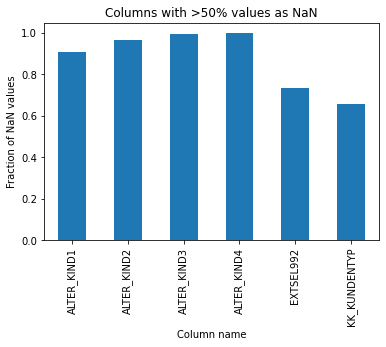

In [19]:
# Show columns with more than 50% null values
get_null_fractions(azdias, threshold=0.5, plot=True)

We can see that there are six columns with over half null values. There may be more once we have run the function to replace the additional values for unknown data with NaN. We will later drop these columns from the dataset with the following function.

In [20]:
def drop_columns(df, columns):
    ''' Drop columns from the dataframe
    
    Args:
        df (DataFrame): dataframe to process
        columns (list): columns to drop
    Return:
        df_dropped (DataFrame): dataframe with columns dropped
    '''
    df_dropped = df.drop(labels=columns, axis=1)
    
    return df_dropped

Now let's look at missing values by row.

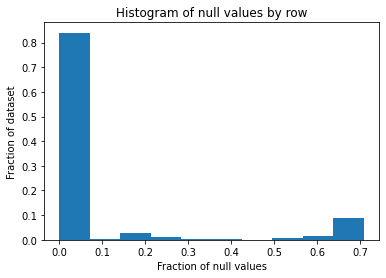

In [21]:
# Calculate the fraction of null values on each row of the dataframe
fraction_null_by_row = azdias.isna().mean(axis=1)

# Plot a weighted histogram of the result
plt.hist(fraction_null_by_row, weights=np.ones(len(fraction_null_by_row)) / len(fraction_null_by_row))
plt.xlabel("Fraction of null values")
plt.ylabel("Fraction of dataset")
plt.title("Histogram of null values by row");

We can see that most of the rows (>80%) have few missing values (<20%), so we can quite agressively remove rows with missing values without significantly impacting the size of our dataset. We'll drop rows with >20% missing values.

In [22]:
def drop_rows_with_missing_values(df, threshold):
    ''' Drop rows in the dataframe where the fraction of missing values exceeds a threshold
    
    Args:
        df (DataFrame): dataframe to process
        threshold (float): threshold of missing values above which a row will be dropped
    Returns:
        df_dropped (DataFrame): processed dataframe
    '''
    fraction_null_by_row = df.isna().mean(axis=1)
    # Get indices of rows where the threshold of null values is exceeded
    idx_to_drop = fraction_null_by_row[fraction_null_by_row > threshold].index
    # Drop these from the dataframe
    df_dropped = df.drop(labels=idx_to_drop, axis=0)
    
    return df_dropped

### 0.3 Non-numeric columns
There are a few remaining non-numeric columns in the dataset. As most ML models work best with numeric data, we should convert them where possible.

In [23]:
# Look at non-numeric columns in the dataset
azdias[azdias.columns[azdias.dtypes == 'object']].head()

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ
0,NaN,NaN,NaN,NaN,NaN,NaN
1,8A,8.0,51.0,NaN,1992-02-10 00:00:00,W
2,4C,4.0,24.0,D19_UNBEKANNT,1992-02-12 00:00:00,W
3,2A,2.0,12.0,D19_UNBEKANNT,1997-04-21 00:00:00,W
4,6B,6.0,43.0,D19_SCHUHE,1992-02-12 00:00:00,W


We know from earlier that:
* `CAMEO_DEUG_2015` and `CAMEO_INTL_2015` will be numeric once we have run our cleaning function, and
* `D19_LETZTER_KAUF_BRANCHE` and `EINGEFUEGT_AM` are on the list of unknown columns generated earlier, and will be dropped, and
* `CAMEO_DEU_2015` is a non-numeric column.

Let's look at the remaining column, `OST_WEST_KZ`.

In [24]:
print(azdias['OST_WEST_KZ'].value_counts())

W    629528
O    168545
Name: OST_WEST_KZ, dtype: int64


`CAMEO_DEU_2015` and `OST_WEST_KZ` can be simply encoded numerically using sklearn's `LabelEncoder` function.

In [25]:
def encode_categorical_columns(df, columns, encoders_to_use=None):
    ''' Encode categorical columns with sklearn's LabelEncoder function
    
    Args:
        df (DataFrame): dataframe to process
        columns: categorical columns to encode
        encoders_to_use (list): list of pre-fitted encoders to use, otherwise will be generated (default None)
    Returns:
        df (DataFrame): dataframe with columns encoded
        encoders_used (list): list of fitted encoders used
    '''
    
    encoders_used = []
    
    for i, col in enumerate(columns):
        print("Encoding column '{}'... ".format(col), end="")
        if encoders_to_use is None:
            le = preprocessing.LabelEncoder()
            le.fit(df[col].dropna().unique())
        else:
            le = encoders_to_use[i]
            print("Using existing encoder... ", end="")
        df[col] = le.transform(df[col])
        encoders_used.append(le)
        print("Complete.")
        
    return df, encoders_used

### 0.4 Imputing missing values
For the remaining missing values in the dataset we can fill with the modal value.

In [26]:
def impute_with_mode(df):
    ''' Impute missing values in the dataframe with the most frequent value.
        Uses sklearn's SimpleImputer.
    
    Args:
        df (DataFrame): dataframe to process
    Returns:
        df (DataFrame): dataframe with values imputed
    
    '''
    imputer = SimpleImputer(strategy='most_frequent', missing_values=np.nan)
    imputer = imputer.fit(df)
    
    df.iloc[:,:] = imputer.transform(df)
    
    return df

### 0.5 Bringing it all together
Now we can bring all of the steps together into a single function that will:
1. Remove invalid values (e.g. X, XX)
2. Replace values used for unknown data with NaN
3. Drop columns for which we don't know their meaning
4. Identify and drop columns and rows with lots of missing values
5. Drop or encode non-numeric columns
6. Impute missing values

In [27]:
cat_cols_to_encode = ['CAMEO_DEU_2015', 'OST_WEST_KZ']

def clean_df(df, cols_to_encode, columns_to_drop=None, col_nan_threshold=0.5, row_nan_threshold=0.2, encoders=None):
    ''' Clean dataframe
    
    Args:
        df (DataFrame): DataFrame to clean
        cols_to_encode (list): list of non-numeric columns to encode numerically.
        columns_to_drop (list): list of columns to drop, if known.
            Otherwise columns with null fraction > col_nan_threshold will be dropped (default None).
        col_nan_threshold (float): fraction of null values allowed before column is dropped (default 0.5).
        row_nan_threshold (float): fraction of null values allowed before row is dropped (default 0.2).
        encoders (list): list of pre-fitted encoders to use with coles_to_encode (default None)
    Returns:
        df_clean (DataFrame): cleaned DataFrame
        cols_with_missing (list): list of columns with null fraction > col_nan_threshold that were dropped.
        encoders (list): list of fitted encoders used with coles_to_encode
    
    '''
    # Replace invalid X values
    print('Replacing invalid X values... ')
    df_clean = replace_invalid_x_values(df)
    print('Complete.')

    # Replace values used for unknown data with np.nan
    print('Replacing unknown values with NaN... ', end='')
    df_clean, _ = replace_unknown_with_nan(df_clean, unknown_value_dict)
    print('Complete.')

    # Drop columns for which we don't know their meaning
    print('Dropping unknown columns... ', end='')
    df_clean = drop_columns(df_clean, unknown_columns)
    print('Complete.')

    # Find columns with nan fraction over threshold, and drop
    # If columns passed as argument, use these instead
    if columns_to_drop is None:
        cols_with_missing = get_null_fractions(df_clean, threshold=col_nan_threshold)
    else:
        cols_with_missing = columns_to_drop

    print('Finding and dropping columns with over {:.0%} NaN... '.format(col_nan_threshold), end='')
    df_clean = drop_columns(df_clean, cols_with_missing.index)
    print('Complete.')

    # Find rows with nan fraction over threshold, and drop
    print('Finding and dropping rows with over {:.0%} NaN... '.format(row_nan_threshold), end='')
    df_clean = drop_rows_with_missing_values(df_clean, threshold=row_nan_threshold)
    print('Complete.')

    # Impute nan values with most frequent value
    print('Imputing NaN values with most frequent values... ', end='')
    df_clean = impute_with_mode(df_clean)
    print('Complete.')

    # Encode non-numeric columns, using pre-fitted encoders if given
    print('Encoding non-numeric columns... ')
    if encoders is None:
        df_clean, encoders = encode_categorical_columns(df_clean, cat_cols_to_encode)
    else:
        df_clean, encoders = encode_categorical_columns(df_clean, cat_cols_to_encode, encoders_to_use=encoders)
    print('Complete.')

    # Return cleaned dataframe
    print('Cleaned dataframe returned.')
    return df_clean, cols_with_missing, encoders

def clean_dataframes(df_azdias, df_customers, cols_to_encode):
    ''' Cleans the two dataframes, dropping same columns in df_customers as found in df_azdias
    
    Args:
        df_azdias (DataFrame): DataFrame of general population
        df_customers (DataFrame): DataFrame of customers
        cols_to_encode (list): list of non-numeric columns to encode numerically 
    Returns:
        df_azdias_clean (DataFrame): Cleaned dataframe of general population
        df_customers_clean (DataFrame): Cleaned dataframe of customers
    '''
    
    print('Cleaning azdias dataframe...')
    df_azdias_clean, cols_to_drop, encoders = clean_df(df_azdias, cat_cols_to_encode)
    print('==========')
    print('Cleaning customers dataframe...')
    df_customers_clean, _, _ = clean_df(df_customers, cat_cols_to_encode, cols_to_drop, encoders=encoders)

    # Return cleaned dataframe
    return df_azdias_clean, df_customers_clean

In [28]:
azdias_clean, customers_clean = clean_dataframes(azdias, customers, cat_cols_to_encode)

Cleaning azdias dataframe...
Replacing invalid X values... 
Found 373 values matching '/X+/' in column 'CAMEO_DEU_2015'. replaced with NaN.
Found 373 values matching '/X+/' in column 'CAMEO_DEUG_2015'. replaced with NaN.
Found 373 values matching '/X+/' in column 'CAMEO_INTL_2015'. replaced with NaN.
Complete.
Replacing unknown values with NaN... Complete.
Dropping unknown columns... Complete.
Finding and dropping columns with over 50% NaN... Complete.
Finding and dropping rows with over 20% NaN... Complete.
Imputing NaN values with most frequent values... Complete.
Encoding non-numeric columns... 
Encoding column 'CAMEO_DEU_2015'... Complete.
Encoding column 'OST_WEST_KZ'... Complete.
Complete.
Cleaned dataframe returned.
Cleaning customers dataframe...
Replacing invalid X values... 
Found 126 values matching '/X+/' in column 'CAMEO_DEU_2015'. replaced with NaN.
Found 126 values matching '/X+/' in column 'CAMEO_DEUG_2015'. replaced with NaN.
Found 126 values matching '/X+/' in column 

Now that we've cleaned the dataframes, let's re-run the overview function to see how they are looking.

In [29]:
print('Overview of azdias_clean:')
dataframe_overview(azdias_clean)
print('')
print('Overview of customers_clean:')
dataframe_overview(customers_clean)

Overview of azdias_clean:
737288 rows and 269 columns.
269 columns of type 'number'.
0 columns of type 'object'.
0% of the data is null.

Overview of customers_clean:
134246 rows and 272 columns.
270 columns of type 'number'.
2 columns of type 'object'.
0% of the data is null.


Great! We've got no null values, and the only non-numeric columns are two of the extra columns in the customers dataframe (expected).

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

To describe the relationship between the demographics of the company's existing customers and the general population of Germany we will use *k*-means clustering. To reduce the computational complexity we first want to reduce the dimensionality of the datasets. We will do this with PCA (Principal Component Analysis); identifying the aspects of the data that explain the majority of the variance seen in the data.

### 1.1 Principal Component Analysis
To perform PCA, we first need to scale the data such that each column has the same variance. We can use sklearn's [`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) to do this.

In [30]:
scaler = preprocessing.StandardScaler()
azdias_scaled = scaler.fit(azdias_clean).transform(azdias_clean)

Now we can apply PCA, and look at how the number of components relates to the level of explained variance.

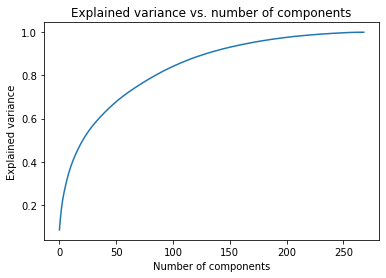

In [31]:
pca = PCA()
pca.fit(azdias_scaled)

# Plot explained variance against number of components
cum_var = np.cumsum(pca.explained_variance_ratio_)
plt.plot(cum_var)
plt.xlabel('Number of components')
plt.ylabel('Explained variance')
plt.title('Explained variance vs. number of components');

In [32]:
var_threshold = 0.85
num_components = np.where(cum_var > 0.85)[0][0]

print('{} components can be used to explain {:.0%} of the variance.'.format(num_components, var_threshold))

104 components can be used to explain 85% of the variance.


We can see from the PCA analysis that we only need 104 components to explain 85% of the variance in the dataset. We can repeat the PCA process with this number of components to produce a reduced dataset for use with *k*-means clustering.

In [33]:
pca = PCA(n_components=num_components)
azdias_reduced = pca.fit(azdias_scaled).transform(azdias_scaled)

In [34]:
# Verify that the reduced dataset has the properties we expect
print('Shape of reduced dataset: {}'.format(azdias_reduced.shape))
print('{:.0%} variance explained.'.format(np.sum(pca.explained_variance_ratio_)))

Shape of reduced dataset: (737288, 104)
85% variance explained.


### 1.2 *k*-means clustering
We can now apply *k*-means clustering to the reduced dataset. The optimal number of clusters, *k*, can be determined by using the elbow method. We will run through a range of number of clusters, and store the interia (sum of squared distances of samples to their closest cluster center) for each. By plotting this we will find the lowest value of *k* that provides a good (low) intertia value. 

In [37]:
# Range of k values to test
k_range = range(1,16)
# List to store the inertia values in
inertias = []
# Iterate through k values, storing inertia values
for k in k_range:
    kmc = KMeans(n_clusters=k, init='k-means++')
    kmc.fit(azdias_reduced)
    inertias.append(kmc.inertia_)
    print('{} clusters, inertia={:.0f}.'.format(k, kmc.inertia_))

1 clusters, inertia=168129485.
2 clusters, inertia=156179134.
3 clusters, inertia=150780807.
4 clusters, inertia=146404043.
5 clusters, inertia=142975405.
6 clusters, inertia=140879988.
7 clusters, inertia=139133659.
8 clusters, inertia=137468483.
9 clusters, inertia=135943043.
10 clusters, inertia=134786737.
11 clusters, inertia=133773571.
12 clusters, inertia=132929901.
13 clusters, inertia=132179747.
14 clusters, inertia=131506620.
15 clusters, inertia=130889471.


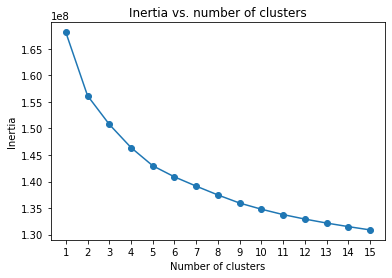

In [38]:
# Plot inertia vs. the number of clusters
plt.plot(k_range, inertias, '-o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Inertia vs. number of clusters')
plt.xticks(k_range);

Whilst there isn't a sharp 'elbow', we can see that by *k*=10 the curve has flattened considerably. We will use this value.

In [39]:
k_clusters = 10

Using the azdias dataset we've determined:

1. The number of components to use in PCA to reduce the dimensionality, and
2. The number of clusters to use in *k*-means clustering.

We can now create a pipeline with all of the required steps (scale, reduce, cluster). We will `fit()` the pipeline using the azdias dataset, and then use `predict()` on both datasets.

In [40]:
# Define the pipeline of transformations required
# Setting a static random_state for PCA and KMeans to give repeatable output
pipeline = Pipeline([
    ('scale', preprocessing.StandardScaler()),
    ('reduce', PCA(n_components=num_components, random_state=42)),
    ('cluster', KMeans(n_clusters=k_clusters, init='k-means++', random_state=21))
])

# Fit the pipeline on the azdias data
pipeline.fit(azdias_clean)

# Predict to get the clustered data
azdias_clustered = pipeline.predict(azdias_clean)
azdias_clustered_df = pd.DataFrame(azdias_clustered, columns=['Cluster'])

# For the customers data, select only columns that are in the azdias dataset (i.e. not the extra 3)
customers_clustered = pipeline.predict(customers_clean[azdias_clean.columns])
customers_clustered_df = pd.DataFrame(customers_clustered, columns=['Cluster'])

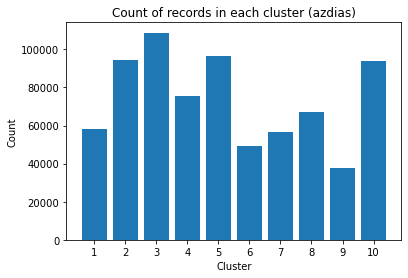

In [41]:
azdias_counts = azdias_clustered_df.value_counts().sort_index()

plt.bar(np.arange(k_clusters)+1, azdias_counts.values)
plt.xticks(np.arange(k_clusters)+1)
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.title('Count of records in each cluster (azdias)');

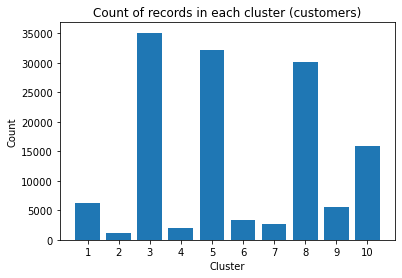

In [42]:
customers_counts = customers_clustered_df.value_counts().sort_index()

plt.bar(np.arange(k_clusters)+1, customers_counts.values)
plt.xticks(np.arange(k_clusters)+1)
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.title('Count of records in each cluster (customers)');

### 1.3 Comparison of customers to overall population
Now that we have clustered both the overall population data and the customers data, we can compare them and determine which parts of the population are more or less likely to be customers.

In [43]:
# Combine the cluster information into a single df, and calculate proportions and differences
df_clusters = pd.DataFrame(index=np.arange(k_clusters)+1, columns=['Population Abs.', 'Customers Abs.'])
# Insert absolute counts of each cluster
df_clusters['Population Abs.'] = azdias_counts.values
df_clusters['Customers Abs.'] = customers_counts.values
# Normalise relative to number of records in each dataset
df_clusters['Population %'] = 100*df_clusters['Population Abs.'] / azdias_counts.sum()
df_clusters['Customers %'] = 100*df_clusters['Customers Abs.'] / customers_counts.sum()
# Calculate the difference between the customers and population dataset
df_clusters['Delta'] = df_clusters['Customers %']-df_clusters['Population %']

df_clusters

,Population Abs.,Customers Abs.,Population %,Customers %,Delta
1,57924,6222,7.856360,4.634775,-3.221585
2,94448,1138,12.810191,0.847698,-11.962493
3,108734,35120,14.747833,26.160928,11.413096
4,75606,1969,10.254609,1.466710,-8.787898
5,96289,32219,13.059890,23.999970,10.940080
6,49343,3386,6.692500,2.522235,-4.170265
7,56556,2697,7.670815,2.008998,-5.661817
8,67140,30102,9.106347,22.423014,13.316668
9,37480,5484,5.083495,4.085038,-0.998457
10,93768,15909,12.717961,11.850632,-0.867329


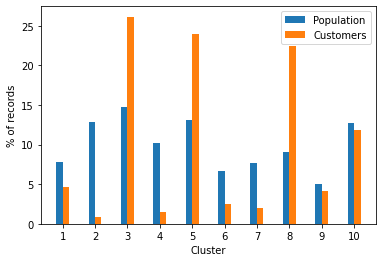

In [44]:
# Plot the % of records in each cluster for both the customers and overall population
plt.bar([x-0.1 for x in df_clusters.index], height=df_clusters['Population %'], width=0.2)
plt.bar([x+0.1 for x in df_clusters.index], height=df_clusters['Customers %'], width=0.2)
plt.xticks(df_clusters.index)
plt.xlabel('Cluster')
plt.ylabel('% of records')
plt.legend(['Population', 'Customers']);

We can see that there are significant differences. These will be easier to see if we just plot the sorted differences.

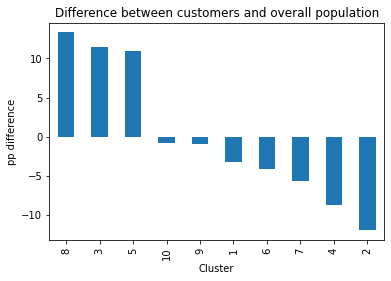

In [45]:
# Sort the dataframe by the size of the difference
df_clusters = df_clusters.sort_values(by='Delta', ascending=False)

# Plot the differences between the customers data and the overall population
df_clusters['Delta'].plot.bar()
plt.xlabel('Cluster')
plt.ylabel('pp difference')
plt.title('Difference between customers and overall population');

In [46]:
# Pull out the top and bottom two clusters
top_two = list(df_clusters.index[:2])
bottom_two = list(df_clusters.index[-2:])

print('Clusters {} have higher representation in the customers dataset.'.format(top_two))
print('Clusters {} have lower representation in the customers dataset.'.format(bottom_two))

Clusters [8, 3] have higher representation in the customers dataset.
Clusters [4, 2] have lower representation in the customers dataset.


### 1.4 Cluster meanings

We know now which clusters are over- and under-represented in the customers dataset versus the general population. To interpret the meanings of these clusters, and therefore understand the demographic factors that make someone more or less likely to be a customer, we can run the inverse of the steps in the pipeline to get back to the original, untransformed data.

In [47]:
def sorted_columns_from_cluster(pl, cluster):
    ''' Invert the pipeline operations to recover data in original form,
        and sort by most impactful columns for a given cluster.
        
    Args:
        pl (Pipeline): pipeline to invert
        cluster (int): cluster number to investigate
    Returns:
        cluster_df (DataFrame): DataFrame with column names as index, scaled
        and unscaled values, sorted by scaled value descending
    '''
    # Get scale, reduce, and cluster steps from pipeline
    scl = pl.named_steps['scale']
    pca = pl.named_steps['reduce']
    kmc = pl.named_steps['cluster']
    
    # Invert the PCA transform on the cluster centre. Gives scaled values.
    inv_cluster = pca.inverse_transform(kmc.cluster_centers_[cluster-1])
    # Put the values into a dataframe
    cluster_df = pd.DataFrame(np.round(inv_cluster, 2), index=azdias_clean.columns, columns=['Scaled Value'])
    # Invert the scaling and add these values to the dataframe
    cluster_df['Value'] = np.round(scl.inverse_transform(inv_cluster), 1)
    # Sort by the scaled value - largest impact first
    cluster_df.sort_values(by='Scaled Value', ascending=False, inplace=True)
    
    return cluster_df

def display_cluster_meaning(pl, cluster_numbers, display_n=5):
    ''' Displays the top indicators for a given cluster number by inverting the
        steps of the pipeline to recover the original, untransformed data.
    
    Args:
        pl (Pipline): pipeline with scale, reduce, and cluster steps
        cluster_number (list): list of cluster numbers to display meaning of
        display_n (int): number of indicators to display (default 5)
    '''
    
    for c in cluster_numbers:
        cluster_df = sorted_columns_from_cluster(pl, c)

        # Get descriptions and meanings for each factor
        descriptions = []
        meanings = []

        for i in range(len(cluster_df)):
            # Get the description of the factor
            attr = attributes_df[attributes_df['Attribute'] == cluster_df.iloc[i].name]
            descriptions.append(attr['Description'].values[0])
            # Try to look up the meaning of the value
            # This is a quick approach that doesn't always succeed
            val = np.floor(cluster_df.iloc[i]['Value'])
            try:
                meaning = list(attr[attr['Value'] == val]['Meaning'])[0]
            # If there isn't a match (due to encoding etc.), just fill with nan
            except:
                meaning = np.nan
            meanings.append(meaning)

        cluster_df['Description'] = descriptions
        cluster_df['Meaning'] = meanings

        # Display the result using Ipython.display to format nicely
        display_markdown('Top {} indicators in cluster {}'.format(display_n, c), raw=True)
        display(cluster_df.head(display_n))
        display_markdown('---', raw=True)

In [48]:
# Display meanings of the top and bottom two clusters
display_markdown('#### Top positive clusters for customers', raw=True)
display_cluster_meaning(pipeline, top_two)
display_markdown('#### Top negative clusters for customers', raw=True)
display_cluster_meaning(pipeline, bottom_two)

#### Top positive clusters for customers

Top 5 indicators in cluster 8

,Scaled Value,Value,Description,Meaning
KBA13_HERST_BMW_BENZ,1.15,4.3,share of BMW & Mercedes Benz within the PLZ8,high
KBA13_KMH_211,1.08,4.1,share of cars with a greater max speed than 21...,high
KBA05_KW3,1.07,2.7,share of cars with an engine power of more tha...,average
KBA13_KMH_250,1.06,4.0,share of cars with max speed between 210 and 2...,high
KBA13_KW_121,1.05,4.0,share of cars with an engine power more than 1...,high


---

Top 5 indicators in cluster 3

,Scaled Value,Value,Description,Meaning
FINANZ_MINIMALIST,0.93,4.3,financial typology: low financial interest,low
LP_STATUS_FEIN,0.89,7.8,social status fine,title holder-households
LP_STATUS_GROB,0.89,3.8,social status rough,average earners
MOBI_REGIO,0.86,4.2,moving patterns,low mobility
KBA05_ANTG1,0.85,2.7,number of 1-2 family houses in the cell,average share of 1-2 family homes


---

#### Top negative clusters for customers

Top 5 indicators in cluster 4

,Scaled Value,Value,Description,Meaning
CAMEO_DEUG_2015,1.03,8.1,CAMEO classification 2015 - Uppergroup,working class
CAMEO_DEU_2015,1.02,36.3,CAMEO classification 2015 - detailled classifi...,NaN
PLZ8_ANTG3,1.01,2.6,number of 6-10 family houses in the PLZ8,average share
PLZ8_ANTG4,0.99,1.4,number of >10 family houses in the PLZ8,low share
PLZ8_BAUMAX,0.99,3.4,most common building-type within the PLZ8,mainly 6-10 family homes


---

Top 5 indicators in cluster 2

,Scaled Value,Value,Description,Meaning
FINANZ_UNAUFFAELLIGER,0.98,4.0,financial typology: unremarkable,low
FINANZ_SPARER,0.97,4.2,financial typology: money saver,low
SEMIO_PFLICHT,0.89,5.9,affinity indicating in what way the person is ...,low affinity
FINANZ_ANLEGER,0.87,4.1,financial typology: investor,low
PRAEGENDE_JUGENDJAHRE,0.87,12.9,dominating movement in the person's youth (ava...,80ies - FDJ / communist party youth organisati...


---

From this we can describe what characteristics make a person in the general population more or less likely to be a customer.

From clusters 8 and 3 we can see that customers are **more** likely to:
* Live in an area with a high proportion high-end cars (BMW and Mercedes-Benz)
* Live in an area with a high proportion of high-powered cars (max. speed > 210 kph, engine power > 121 kW)
* Low mobility, owning homes in lower density areas
* Have average income
* Have interest in finances (inferred from "low financial interest" being "low")

From clusters 4 and 2 we can see that customers are **less** likely to:
* Be financial investors or money savers
* Be "working class"
* Live in an area with mainly 6-10 family homes (i.e. high density)

**In summary: financially-aware people with average income, but high expenditure (high-end cars, home ownership) are most likely to be customers.**

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [49]:
# mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')
mailout_train = pd.read_csv('./Data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

/Users/guy/miniforge3/envs/.venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


### 2.1 Cleaning the data
As with the previous data files, we need to clean the data before we can use it to generate a model. We can use the same functions that we defined previously to do this.

First, let's look at an overview.

In [50]:
dataframe_overview(mailout_train)

42962 rows and 367 columns.
361 columns of type 'number'.
6 columns of type 'object'.
14% of the data is null.


Now let's apply the same cleaning steps to the data. As a reminder, this will:
1. Remove invalid values (e.g. X, XX)
2. Replace values used for unknown data with NaN
3. Drop columns for which we don't know their meaning
4. Identify and drop columns and rows with lots of missing values
5. Drop or encode non-numeric columns
6. Impute missing values

In [51]:
mailout_train_clean, mailout_dropped_cols, mailout_encoders = clean_df(mailout_train, cat_cols_to_encode)

Replacing invalid X values... 
Found 11 values matching '/X+/' in column 'CAMEO_DEU_2015'. replaced with NaN.
Found 11 values matching '/X+/' in column 'CAMEO_DEUG_2015'. replaced with NaN.
Found 11 values matching '/X+/' in column 'CAMEO_INTL_2015'. replaced with NaN.
Complete.
Replacing unknown values with NaN... Complete.
Dropping unknown columns... Complete.
Finding and dropping columns with over 50% NaN... Complete.
Finding and dropping rows with over 20% NaN... Complete.
Imputing NaN values with most frequent values... Complete.
Encoding non-numeric columns... 
Encoding column 'CAMEO_DEU_2015'... Complete.
Encoding column 'OST_WEST_KZ'... Complete.
Complete.
Cleaned dataframe returned.


Let's see what it looks like now.

In [52]:
dataframe_overview(mailout_train_clean)

mailout_dropped_cols

33837 rows and 271 columns.
271 columns of type 'number'.
0 columns of type 'object'.
0% of the data is null.


KBA05_BAUMAX    0.534891
TITEL_KZ        0.995042
dtype: float64

Great! We've removed or imputed all the null data, and have only numeric columns in the dataset. Two columns were dropped due to high fractions of null values: `KBA05_BAUMAX` and `TITEL_KZ`, with 53% and 99% null values, respectively.

### 2.2 Addressing imbalance
The `RESPONSE` column contains the values we want to predict. Let's take a look at this column in more detail.

0    33421
1      416
Name: RESPONSE, dtype: int64


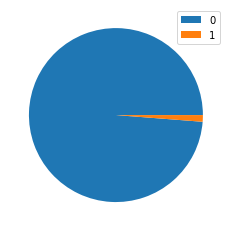

In [53]:
# Print and plot the counts of values in the RESPONSE column
response_counts = mailout_train_clean['RESPONSE'].value_counts()
print(response_counts)

plt.pie(response_counts)
plt.legend(response_counts.index);

We can see that this is very imbalanced; there are ~80x more zeroes (no reponse) compared to ones (reponse). We need to address this imbalanced before creating our model, otherwise it's likely that the model will overpredict the minority class (no response) as an outcome.

We will use **S**ynthetic **M**inority **O**versampling **Te**chnique (SMOTE) to generate synthetic observations of the minority class to bring the dataset back into balance. We will use `imblearn`'s [SMOTE()](https://imbalanced-learn.org/dev/references/generated/imblearn.over_sampling.SMOTE.html) class for this. This will be performed on the training data only - test data should only be real data.

In [54]:
# Split the data into X (factors) and y (response) dataframes
y = mailout_train_clean['RESPONSE']
X = mailout_train_clean.drop(columns=['RESPONSE'])

# Split into test and train datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Use a static random state for repeatability during testing
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

0    25054
1    25054
Name: RESPONSE, dtype: int64


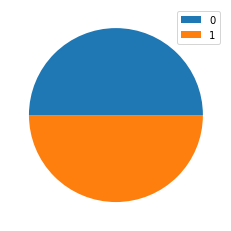

In [55]:
# Let's check that it's had the effect we expect
response_counts = y_train_res.value_counts()
print(response_counts)

plt.pie(response_counts)
plt.legend(response_counts.index);

We can see that our resampled training data now has an equal number of points in the two output classes (zero and one).
### 2.3 Evaluating different modelling approaches
Now that we have clean and balanced data, we can begin to generate models and evaluate their performance. The variables we're going to explore are:

1. Inclusion of all columns, versus the most impactful columns as found in our unsupervised model in part 1.
2. Different machine learning models (e.g. Random Forest, AdaBoost, Gradient Boost).
3. Hyperparameter tuning of the best model/columns combination using GridSearchCV.

For (1), we will take the top two clusters that positively correlate with customers, and the bottom two clusters that negatively correlated with customers (we identified these in section 1.3). From each of these we'll take the 30 columns that had the biggest impact on the cluster, for a total of 120 columns. Some columns may appear in more than one cluster, so we'll then remove duplicates to give us our final list of most impactful columns.

In [56]:
# Top two positive correlating clusters and negative correlating clusters
most_impactful_clusters = top_two + bottom_two

most_impactful_columns = []

for cluster in most_impactful_clusters:
    # Get columns and values from the cluster
    df_cluster = sorted_columns_from_cluster(pipeline, cluster)
    # Add the top 30 columns to the list of impactful columns
    most_impactful_columns += list(df_cluster.index)[:30]
    
# Create a set to remove any duplicated columns
most_impactful_columns = set(most_impactful_columns)

print('Selected {} columns with best potential to identify a customer.'.format(len(most_impactful_columns)))

Selected 104 columns with best potential to identify a customer.


In [57]:
def generate_evaluate_model(X_train, X_test, y_train, y_test, model, model_title):
    '''
    '''    
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_test)
#     y_pred_class = y_pred[:,1] > 0.5
    
    roc_auc = roc_auc_score(y_test, y_pred[:,1])
    fp_rate, tp_rate, threshold = roc_curve(y_test, y_pred[:,1])

    print('ROC AUC score: {}'.format(roc_auc))
    plt.plot(fp_rate, tp_rate)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve: {}'.format(model_title))
    plt.show();
    
    return roc_auc

LogisticRegression (All columns)
ROC AUC score: 0.5318628868403906


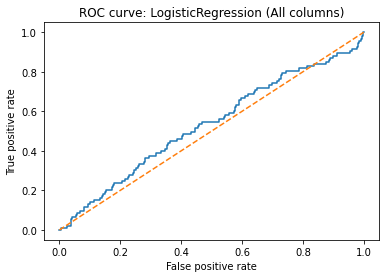

LogisticRegression (Most impactful columns)
ROC AUC score: 0.5635619195225483


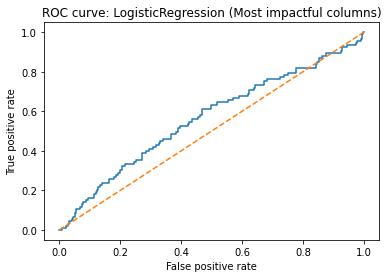

RandomForest (All columns)
ROC AUC score: 0.5457268763228814


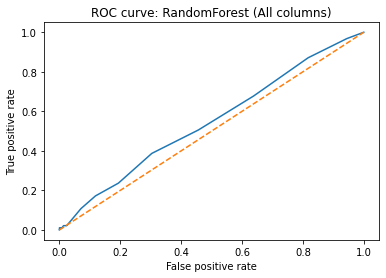

RandomForest (Most impactful columns)
ROC AUC score: 0.5862264837154669


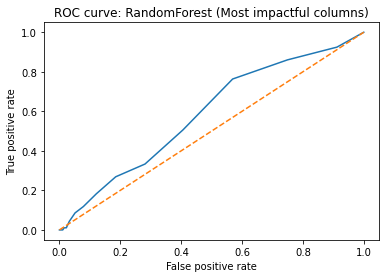

AdaBoost (All columns)
ROC AUC score: 0.5641466539695759


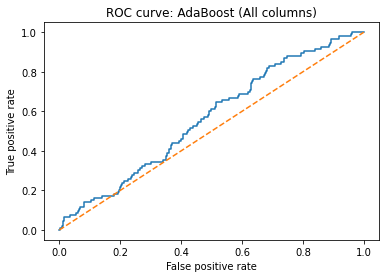

AdaBoost (Most impactful columns)
ROC AUC score: 0.5650693777782919


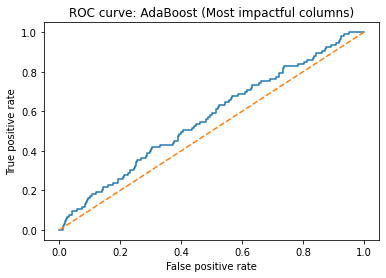

GradientBoosting (All columns)
ROC AUC score: 0.5607757562672608


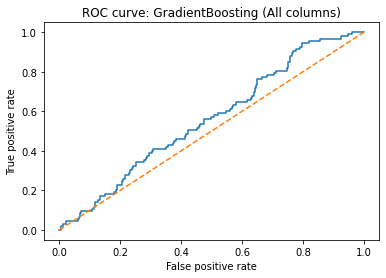

GradientBoosting (Most impactful columns)
ROC AUC score: 0.5625890756183728


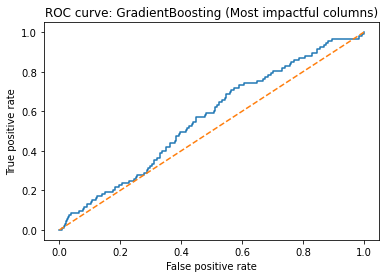

In [330]:
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'RandomForest' : RandomForestClassifier(n_jobs=-1),
    'AdaBoost': AdaBoostClassifier(),
    'GradientBoosting': GradientBoostingClassifier()
}

columns = {
    'All columns': X_train_res.columns,
    'Most impactful columns': most_impactful_columns
}

results = {}

for model_name, model in models.items():
    pl = Pipeline([
        ('scale', preprocessing.MinMaxScaler()),
        ('clf', model)
    ])
    
    for cols_name, cols in columns.items():
        model_title = '{} ({})'.format(model_name, cols_name)
        print(model_title)
        score = generate_evaluate_model(X_train_res[cols], X_test[cols], y_train_res, y_test, pl, model_title)
        results[model_title] = score

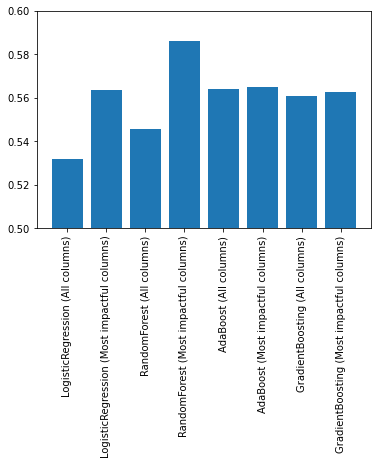

In [346]:
plt.bar(results.keys(), height=results.values())
plt.ylim([0.5, 0.6])
plt.xticks(rotation=90);

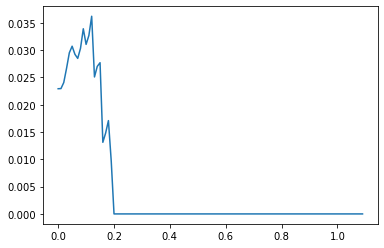

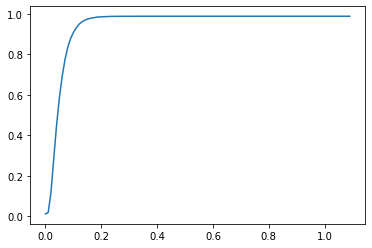

In [274]:
y_pred_prob = m.predict_proba(X_test[most_impactful_columns])
y_pred = m.predict(X_test[most_impactful_columns])

threshold_range = np.arange(0, 1.1, 0.01)
f1_scores = []
accuracy_scores = []

for t in threshold_range:
    y_pred_class = (y_pred_prob[:, 1] > t)*1
    f1_scores.append(f1_score(y_test, y_pred_class))
    accuracy_scores.append(accuracy_score(y_test, y_pred_class))
    
plt.plot(threshold_range, f1_scores);
plt.show()
plt.plot(threshold_range, accuracy_scores);

In [275]:
threshold_range[np.where(f1_scores == np.max(f1_scores))[0][0]]
np.max(f1_scores)

0.036211699164345405